<a href="https://colab.research.google.com/github/xiaomuc/opencv/blob/master/face_dlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import cv2
import numpy as np
import matplotlib.patches as patches
from IPython.display import clear_output
import matplotlib.pylab as plt
import os

try:
    import google.colab
    IN_COLAB = True
    %matplotlib inline
    from google.colab import drive
    from google.colab.patches import cv2_imshow
    drive.mount('/content/gdrive')
    DRIVE_ROOT='/content/gdrive/My Drive/opencv/'
    !pip install face_recognition
except:
    IN_COLAB =False
    %matplotlib notebook  
    DRIVE_ROOT='./'

import face_recognition
face_dir = os.path.join(DRIVE_ROOT,'known_face')
OUT_DIR =os.path.join(DRIVE_ROOT,'output')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# definition part
face_dir = os.path.join(DRIVE_ROOT,'known_face')
OUT_DIR =os.path.join(DRIVE_ROOT,'output')

# my son
son_image = face_recognition.load_image_file('./training-data/s1/1.JPG')
son_face_encoding = face_recognition.face_encodings(son_image)[0]

# suzu
suzu_image = face_recognition.load_image_file('./training-data/s4/7.jpg')
suzu_face_encodeing = face_recognition.face_encodings(suzu_image)[0]

# shishamo
asa_image = face_recognition.load_image_file('./training-data/s5/2.jpg')
asa_face_encodeing = face_recognition.face_encodings(asa_image)[0]

known_face_encodings = [
    son_face_encoding,
    suzu_face_encodeing,
    asa_face_encodeing
]
known_face_names =[
    "Toma",
    "Suzu",
    "Asako"
]

#image=cv2.imread("img_interviewMovie.jpg")


FileNotFoundError: ignored

In [3]:
known_face_encodings=[]
known_face_names=[]
subject_image_names=os.listdir(face_dir)
for image_name in subject_image_names:
    if image_name.startswith("."):
        continue
    name=os.path.splitext(image_name)[0];
    image_path = os.path.join(face_dir,image_name)
    image = face_recognition.load_image_file(image_path)
    face_encoding = face_recognition.face_encodings(image)[0]
    known_face_encodings.append(face_encoding)
    known_face_names.append(name)
    print(name)

Asako
ClassMate1
Girl1
ClassMate2
Suzu
Toma


In [0]:
# single frame recognition
def recognize_face(frame,do_scale=False,threshold=0.5,debug=False):
    face_locations=[]
    face_encodings=[]
    face_names=[]
    
    if do_scale:
        # resize frame to 1/4 size for faster processing
        small_frame = cv2.resize(frame, (0,0), fx=0.25, fy=0.25)
    else:
        small_frame = frame
    result=False   
    # convert the image from BGR color to RGB color
    rgb_small_frame = small_frame[:,:,::-1]
    
    # find all the faces and face encodings in the frame
    face_locations = face_recognition.face_locations(rgb_small_frame)
    #if debug:
        #print(face_locations)
    face_encodings = face_recognition.face_encodings(rgb_small_frame,face_locations)
    result=False
    for face_encoding in face_encodings:
        # see if the face is a match for the known face(s)
        matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
        name = 'Unknown'
        
        # use the known face with the smallest distance
        face_distance = face_recognition.face_distance(known_face_encodings,face_encoding)
        best_match_index = np.argmin(face_distance)
        if matches[best_match_index]:
            if face_distance[best_match_index]<threshold:
                name = known_face_names[best_match_index]
            else:
                name = '?'+known_face_names[best_match_index]+'?'
            if debug:
                print(name,face_distance)
        if name == 'Toma':
            result=True
        face_names.append(name)
    
    #display result
    for(top,right,bottom,left),name in zip(face_locations,face_names):
        #scale back up face locations since the frame detected in was scaled to 1/4 size
        if do_scale:
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4
        
        #draw a box around the face
        cv2.rectangle(frame, (left,top), (right,bottom), (0,0,255),2)
        
        # draw a label with a name below the face
        font = cv2.FONT_HERSHEY_PLAIN
        font_scale = 1.2
        thickness = 2
        margin=1
        
        size = cv2.getTextSize(name, font, font_scale, thickness)
        text_width = size[0][0]
        text_height = size[0][1]
        
        cv2.rectangle(frame, (left, bottom), (left+text_width+margin, bottom+text_height+margin), (0, 0, 255), cv2.FILLED)
        cv2.putText(frame, name, (left,bottom + text_height), font,font_scale, (255,255,255), thickness)
    return result,frame

In [0]:
# detect face locations        
def detect_face_locations(image,do_gray=False,do_scale=False):
    if do_scale:
        small_frame = cv2.resize(image, (0,0), fx=0.25, fy=0.25)
    else:
        small_frame = image
    if do_gray:
        gray = cv2.cvtColor(small_frame,cv2.COLOR_BGR2RGB)
        rgb_frame = gray[:,:,::-1]
    else:
        rgb_frame=small_frame[:,:,::-1]

    face_locations = face_recognition.face_locations(rgb_frame)
    for face_location in face_locations:
        (top,right,bottom,left)=face_location;
        if do_scale:
            top *= 4
            right *= 4
            bottom *= 4
            left *= 4

        cv2.rectangle(image, (left,top), (right,bottom), (0,0,255),2)
        #plt.plot(face_location[1],face_location[0],'bo')
        #plt.plot(face_location[1],face_location[2],'bo')
        #plt.plot(face_location[3],face_location[2],'bo')
        #plt.plot(face_location[3],face_location[0],'bo')
        #plt.show()
    return image

In [0]:
# test functions
# format time(second) as HH:MM:ss.mmm
def format_time(sec):
    msec = (int)(sec * 1000.)
    s, ms = divmod(msec, 1000)
    m, s =divmod(s,60)
    return '{:02d}:{:02d}.{:03d}'.format(m,s,ms)

def format_time_forfile(sec):
    msec = (int)(sec * 1000.)
    s, ms = divmod(msec, 1000)
    m, s =divmod(s,60)
    return '{:02d}m{:02d}s{:03d}ms'.format(m,s,ms)

# single image
def single_image(filename,detect_only=False,debug=False):
#image=cv2.imread("img_interviewMovie.jpg")
    image=cv2.imread(filename)
    if detect_only:
        image=detect_face_locations(image)
    else:
        ret,image=recognize_face(image,debug=debug)
    if IN_COLAB:
      cv2_imshow(image)
    else:
      cv2.imshow("sigle test",image)
      if cv2.waitKey(0) & 0xFF:
        cv2.destroyAllWindows()
    
def getInterval(fps):
    interval =1.0/fps
    time_wait = (int)(interval * 1000.0)
    print('interval: ',interval,'time_wait: ',time_wait)
    return interval,time_wait

def video_proc(filename,output=None,capture=False,detect_only=False,no_wait=False,view=True):
    pre = os.path.splitext(os.path.basename(filename))[0]
    cap = cv2.VideoCapture(filename)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval,time_wait = getInterval(fps)
    time_stamp=0.0
    frame_count=0
    if no_wait:
        time_wait=1
    
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.2
    thickness = 2
    margin=1
    size = cv2.getTextSize(name, font, font_scale, thickness)
    text_width = size[0][0]
    text_height = size[0][1]
    
    # VideoWriter を作成する。
    if output is not None:
        if IN_COLAB:
            fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        else:
            fourcc = cv2.VideoWriter_fourcc(*'DIVX')
        writer = cv2.VideoWriter(os.path.join(OUT_DIR,output), fourcc, fps, (width, height))
    else:
        writer = None

    while cap.isOpened():
        ret,frame = cap.read()
        if not ret:
            cap.release()
            break
        frame_count += 1
        if detect_only:
            frame=detect_face_locations(frame)
        else:
            result,frame=recognize_face(frame)
        cv2.putText(frame,format_time(time_stamp),(margin,margin+text_height),font,font_scale,(0,0,255),thickness)
        if result:
            print(format_time(time_stamp))
            if capture:
                out_name=os.path.join(OUT_DIR,pre+'_'+format_time_forfile(time_stamp)+'.png')
                cv2.imwrite(out_name,frame)
        if not IN_COLAB & view :
            cv2.imshow('video',frame)
            k = cv2.waitKey(time_wait) & 0xff
            if k == 27:
                break;
        if writer is not None:
            writer.write(frame)
        time_stamp += interval
    if not IN_COLAB & view:
        cv2.destroyAllWindows()
    if writer is not None:
        writer.release()
    cap.release()

Asako [0.30180228 0.59395979 0.512498   0.52264266 0.54449186 0.52795648]
Girl1 [0.59707444 0.55976321 0.4591437  0.47823324 0.66754492 0.6495477 ]
Suzu [0.52056481 0.64331749 0.5702427  0.64829475 0.46313831 0.69614388]
?Asako? [0.56245373 0.57865564 0.60538752 0.64515171 0.58075933 0.65474234]


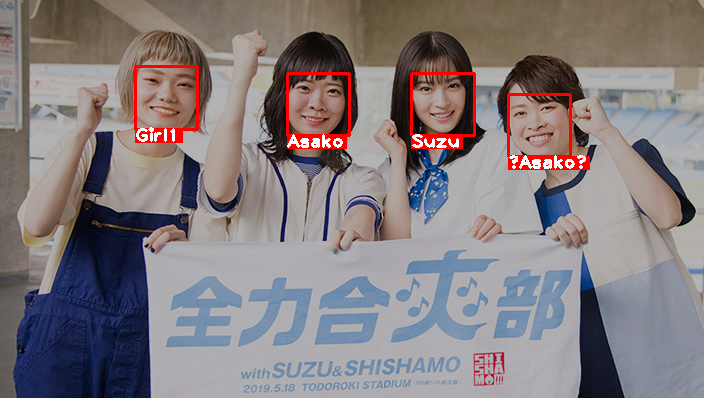

In [10]:
#image_name="./test-data/IMG_6003.jpg"
#image_name="./test-data/IMG_6002.jpg"
image_name=os.path.join(DRIVE_ROOT,"img_interviewMovie.jpg")
single_image(image_name,detect_only=False,debug=True)

In [11]:
import time
video_name=os.path.join(DRIVE_ROOT,"gassou_15sec_small.mp4")
out_name = '15S.avi'
start = time.time()
video_proc(video_name, output=out_name, capture=True, detect_only=False, view=True)
elapsed_time=time.time() - start
print('elapsed time: ',format_time(elapsed_time))

interval:  0.04170833333333333 time_wait:  41
00:07.006
00:11.469
elapsed time:  01:16.312


In [0]:
if IN_COLAB:
  file_name = os.path.join(OUT_DIR,out_name)
  from google.colab import files
  files.download(file_name)